In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from matplotlib import pyplot as plt

In [2]:

class Perceptron:
    def __init__(self, num_features, hidden_layers, num_classes, activations, loss_function):
        self.num_features = num_features
        self.activations = activations
        self.loss_function = loss_function
        self.hidden_layers = hidden_layers
        self.num_classes = num_classes
        self.num_layers = len(hidden_layers) + 1
        self.W = []
        self.B = []
        self.Z = []
        self.A = []
        self.history = None
        self._init_params()

    def _init_params(self):
        self.W.append(np.random.rand(self.hidden_layers[0], self.num_features))  # input - hidden
        first_hidden = 0
        last_hidden = self.num_layers - 2
        for i in range(first_hidden, last_hidden):
            self.W.append(np.random.rand(self.hidden_layers[i + 1], self.hidden_layers[i]))
        # self.W.append(np.random.rand(self.hidden_layers[1], self.hidden_layers[0]))
        # self.W.append(np.random.rand(self.hidden_layers[2], self.hidden_layers[1]))
        self.W.append(np.random.rand(self.num_classes, self.hidden_layers[last_hidden]))  # hidden - output

        for i in range(first_hidden, last_hidden + 1):
            self.B.append(np.random.rand(self.hidden_layers[i]))
        # self.B.append(np.random.rand(self.hidden_layers[0])) # first hidden
        # self.B.append(np.random.rand(self.hidden_layers[1]))
        # self.B.append(np.random.rand(self.hidden_layers[2])) # last hidden
        self.B.append(np.random.rand(self.num_classes))  # output

        for _ in range(self.num_layers):
            # create list placeholders for Z and A
            self.Z.append(None)
        for _ in range(self.num_layers - 1):
            self.A.append(None)
        self.history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    def predict_sample(self, X):
        Z0 = np.dot(self.W[0], X) + self.B[0]
        self.Z[0] = Z0
        A0 = self.activations[0](Z0)
        self.A[0] = A0

        # Z1 = np.dot(self.W[1], A0) + self.B[1]
        # self.Z[1] = Z1
        # A1 = self.activations[1](Z1)
        # self.A[1] = A1
        #
        # Z2 = np.dot(self.W[2], A1) + self.B[2]
        # self.Z[2] = Z2
        # A2 = self.activations[2](Z2)
        # self.A[2] = A2

        for i in range(1, self.num_layers - 1):
            Z = np.dot(self.W[i], self.A[i - 1]) + self.B[i]
            self.Z[i] = Z
            A = self.activations[i](Z)
            self.A[i] = A

        Z_last = np.dot(self.W[-1], self.A[-1]) + self.B[-1]
        self.Z[-1] = Z_last
        A_last = self.activations[-1](Z_last)
        return A_last

    def predict_batch(self, X):
        predictions = []
        for element in X:
            predictions.append(self.predict_sample(element))
        return np.array(predictions)

    def train(self, x_train, y_train, x_test, y_test, learning_rate=0.1, epochs=100):
        for epoch in range(epochs):
            total_losses = 0
            for i in range(len(x_train)):
                x_i = np.array(x_train[i])
                Yh = self.predict_sample(x_train[i])
                loss = self.loss_function(y_train[i], Yh)
                total_losses += loss

                last_hidden = self.num_layers - 2
                first_hidden = 1

                # output layer
                dloss_Yh = self.loss_function(y_train[i], Yh, der=True)
                dloss_A3 = dloss_Yh
                dloss_Z = np.dot(dloss_A3, self.activations[-1](self.Z[-1], der=True))
                dloss_A = np.dot(self.W[-1].T, dloss_Z)
                dloss_W3 = np.kron(dloss_Z, self.A[-1]).reshape(self.num_classes, self.hidden_layers[last_hidden])
                dloss_B3 = dloss_Z

                hd_dloss_Z = []
                hd_dloss_A = []
                hd_dloss_W = []
                hd_dloss_B = []

                for i_hd_lay in reversed(range(first_hidden, last_hidden + 1)):
                    dloss_Z = dloss_A * self.activations[i_hd_lay](self.Z[i_hd_lay], der=True)
                    hd_dloss_Z.insert(0, dloss_Z)
                    dloss_A = np.dot(self.W[i_hd_lay].T, dloss_Z)
                    hd_dloss_A.insert(0, dloss_A)
                    dloss_W1 = np.kron(dloss_Z, self.A[i_hd_lay - 1]).reshape(self.hidden_layers[i_hd_lay],
                                                                              self.hidden_layers[i_hd_lay - 1])
                    hd_dloss_W.insert(0, dloss_W1)
                    dloss_B1 = dloss_Z
                    hd_dloss_B.insert(0, dloss_B1)

                # input layer
                dloss_Z0 = dloss_A * self.activations[0](self.Z[0], der=True)
                dloss_W0 = np.kron(dloss_Z0, x_i).reshape(self.hidden_layers[0], self.num_features)
                dloss_B0 = dloss_Z0

                # output layer
                self.W[-1] -= learning_rate * dloss_W3
                self.B[-1] -= learning_rate * dloss_B3

                # hidden layers
                for i in range(first_hidden, last_hidden):
                    self.W[i + 1] -= learning_rate * hd_dloss_W[i]
                    self.B[i + 1] -= learning_rate * hd_dloss_B[i]
                # input layer
                self.W[0] -= learning_rate * dloss_W0
                self.B[0] -= learning_rate * dloss_B0
            # evaluate the model
            self.history["train_acc"].append(self.score(x_train, y_train))
            self.history["val_acc"].append(self.score(x_test, y_test))
            self.history["train_loss"].append(
                self.loss_function(y_train, self.predict_batch(x_train)) / len(y_train))
            self.history["val_loss"].append(
                self.loss_function(y_test, self.predict_batch(x_test)) / len(y_test))
            if epoch % 50 == 0:
                print(
                    f"epoch: {epoch}; train loss: {self.history['train_loss'][-1]}; val loss: {self.history['val_loss'][-1]}")
                print(f"train acc: {self.history['train_acc'][-1]}; val acc: {self.history['val_acc'][-1]}\n")

    def score(self, X, y):
        predictions = self.predict_batch(X)
        return np.sum(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) / len(y)


def ccategorical_crossentropy(y_true, y_pred, der=False):
    if der:
        return (y_pred - y_true) / y_true.shape
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return -np.sum(y_true * np.log(y_pred))


def sigmoid(x, der=False):
    if der:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))


def softmax(x, der=False):
    if der:
        s = softmax(x)
        return np.diag(s) - np.outer(s, s)
    return (np.exp(x) / np.exp(x).sum())


def relu(x, der=False):
    if der:
        f = np.heaviside(x, 1)
    else:
        f = np.maximum(x, 0)
    return f

In [3]:
X, y = datasets.load_wine(return_X_y=True)
y_cat = []
converter = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
}
for label in y:
    y_cat.append(np.array(converter[label]))
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2)

## 2LP

In [18]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [softmax]
perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)

perceptron.train(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=800)

epoch: 0; train loss: 1.3410446670280687; val loss: 1.4031590153412339
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 50; train loss: 1.0813095393416134; val loss: 1.0768844387600536
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 100; train loss: 1.0748320128039073; val loss: 1.070654286903885
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 150; train loss: 1.067398089600268; val loss: 1.0635436118381192
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 200; train loss: 1.0581196055401763; val loss: 1.0547305188808036
train acc: 0.4225352112676056; val acc: 0.4166666666666667

epoch: 250; train loss: 1.0455389387986602; val loss: 1.0428715656861953
train acc: 0.5845070422535211; val acc: 0.5833333333333334

epoch: 300; train loss: 1.0269392228223948; val loss: 1.025477607891489
train acc: 0.6619718309859155; val acc: 0.6666666666666666

epoch: 350; train loss: 0.9968000342141049; val loss: 0.9975359798601156
tr

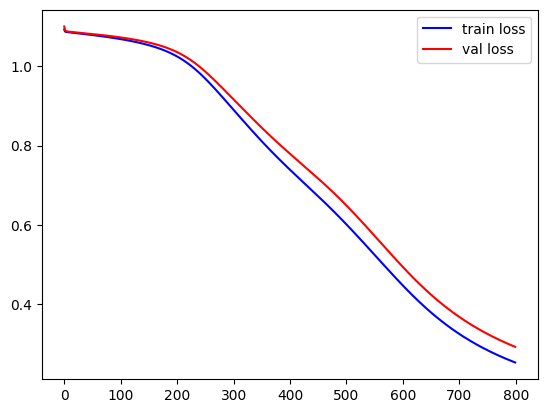

In [7]:


plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()

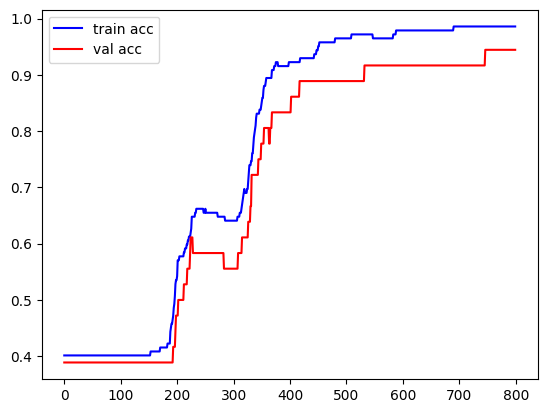

In [8]:
plt.plot(perceptron.history["train_acc"], label="train acc", color="blue")
plt.plot(perceptron.history["val_acc"], label="val acc", color="red")
plt.legend()

## 3LP


In [20]:
hidden_layers = [8, 8]
activations = [sigmoid] * len(hidden_layers) + [softmax]
perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)

perceptron.train(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=800)

epoch: 0; train loss: 1.149201515395722; val loss: 1.1248252056635257
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 50; train loss: 1.0869867513342946; val loss: 1.0843597815508013
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 100; train loss: 1.0869659630164221; val loss: 1.0843330341735584
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 150; train loss: 1.0869452801594088; val loss: 1.0843064023254785
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 200; train loss: 1.0869246956187428; val loss: 1.0842798791652193
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 250; train loss: 1.0869042024827749; val loss: 1.0842534567608173
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 300; train loss: 1.086883793945405; val loss: 1.0842271272919977
train acc: 0.4014084507042254; val acc: 0.3888888888888889

epoch: 350; train loss: 1.0868634632980991; val loss: 1.0842008830415093
t

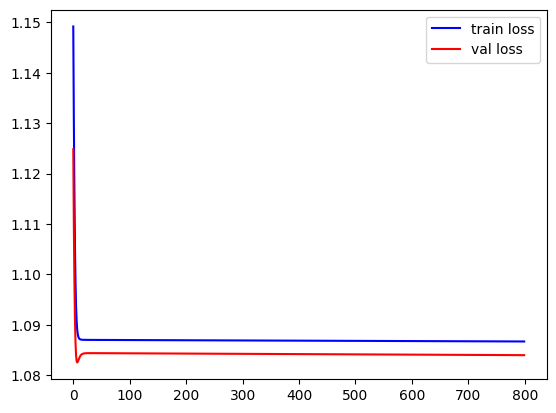

In [21]:
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()

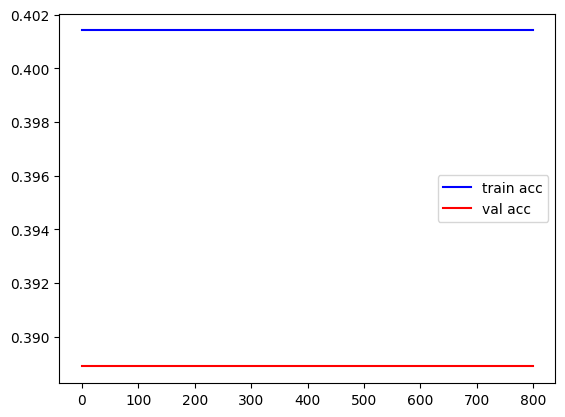

In [17]:
plt.plot(perceptron.history["train_acc"], label="train acc", color="blue")
plt.plot(perceptron.history["val_acc"], label="val acc", color="red")
plt.legend()

vanishing gradient problem

In [4]:
hidden_layers = [8, 8]
activations = [relu] * len(hidden_layers) + [softmax]
perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)

perceptron.train(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=800)

epoch: 0; train loss: 5.576368967229809; val loss: 6.0385249707506246
train acc: 0.14788732394366197; val acc: 0.16666666666666666

epoch: 50; train loss: 4.600334178567676; val loss: 5.084172106295257
train acc: 0.6126760563380281; val acc: 0.5555555555555556

epoch: 100; train loss: 4.150938293517083; val loss: 4.61754601047815
train acc: 0.6126760563380281; val acc: 0.5555555555555556

epoch: 150; train loss: 1.473678669223538; val loss: 1.3196434783682789
train acc: 0.39436619718309857; val acc: 0.4444444444444444

epoch: 200; train loss: 0.9785421837916173; val loss: 0.9160992595820847
train acc: 0.5070422535211268; val acc: 0.6111111111111112

epoch: 250; train loss: 0.49421465533916237; val loss: 0.5271335792061435
train acc: 0.7676056338028169; val acc: 0.6944444444444444

epoch: 300; train loss: 0.26759534701561066; val loss: 0.3489930238233281
train acc: 0.9084507042253521; val acc: 0.8333333333333334

epoch: 350; train loss: 0.16928079982422303; val loss: 0.2692943066424417


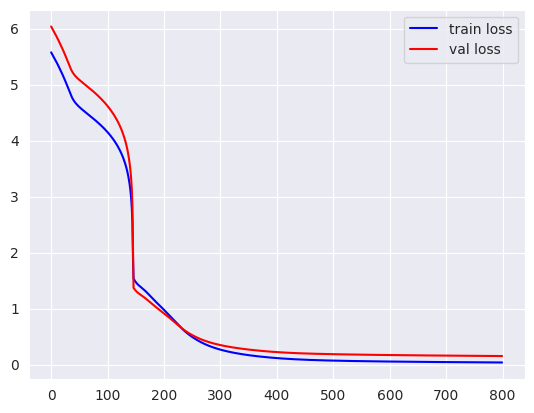

In [7]:
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()

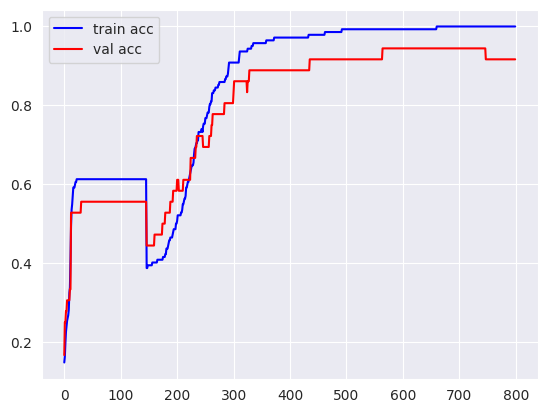

In [8]:
plt.plot(perceptron.history["train_acc"], label="train acc", color="blue")
plt.plot(perceptron.history["val_acc"], label="val acc", color="red")
plt.legend()

so relu was a solution to the vanishing gradient problem


*In deep neural networks, the vanishing gradient problem is a phenomenon where the gradients of the parameters with respect to the loss function become very small, leading to slow or stalled training. It is particularly common in networks with many layers, such as recurrent neural networks (RNNs) and convolutional neural networks (CNNs).

The problem arises because the gradients are multiplied by the weights during backpropagation, and if the weights are small, then the gradients will also be small. This can make it difficult for the network to learn, since the weight updates will be very small and may not be able to overcome the initial randomness of the weights.

There are several ways to address the vanishing gradient problem, including using better weight initialization techniques, using non-linear activation functions such as ReLU, and using techniques such as skip connections and batch normalization.

It is possible that using more than one hidden layer in your perceptron is causing the vanishing gradient problem, leading to poor performance. The vanishing gradient problem is more likely to occur in deeper networks, where there are many layers, so using a single hidden layer may be sufficient for your task.

There could be other factors contributing to the difference in performance as well. For example, the number of units in the hidden layer and the choice of activation function could also impact the network's ability to learn. It is worth experimenting with different architectures and hyperparameters to see what works best for your particular task and dataset.

In general, it is important to be mindful of the vanishing gradient problem when training deep neural networks, and to consider using techniques such as weight initialization, non-linear activation functions, and skip connections to mitigate the issue.*

